In [2]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [3]:
#change the tickers here according to what's in the portfolio
tickers = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", "PG", "PGR", "NEM", "CCI"]

start_date = '2015-01-01'
end_date = '2020-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [4]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2014-12-31 to 2019-12-31
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GNRC    1259 non-null   float64
 1   CPRT    1259 non-null   float64
 2   ODFL    1259 non-null   float64
 3   AMD     1259 non-null   float64
 4   PAYC    1259 non-null   float64
 5   CHTR    1259 non-null   float64
 6   MKC     1259 non-null   float64
 7   PG      1259 non-null   float64
 8   PGR     1259 non-null   float64
 9   NEM     1259 non-null   float64
 10  CCI     1259 non-null   float64
dtypes: float64(11)
memory usage: 118.0 KB


## Function that saves dataframe to CSV

In [5]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [6]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [7]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [8]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [9]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [10]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [11]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [12]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [13]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [14]:
#change to the list of stocks we using
port_list = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", "PG", "PGR", "NEM", "CCI"]

#add in the weightage of stocks
port_shares = [0.05,0.1,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2015-01-01', '2018-01-01', port_shares, port_list)
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total,daily_return
Date,,,,,,,,,,,,,
2015-01-02,2.3185,1.8290,2.531615,0.267,2.606,16.642999,3.281704,7.314266,2.195364,1.685923,6.118071,46.790443,NaN
2015-01-05,2.2990,1.8110,2.467271,0.266,2.518,16.050000,3.226232,7.279491,2.171007,1.696383,6.078829,45.863214,-0.019817
2015-01-06,2.2900,1.7905,2.420892,0.263,2.456,15.631000,3.211588,7.246333,2.144214,1.766993,6.067289,45.287809,-0.012546
2015-01-07,2.2540,1.7960,2.407827,0.258,2.534,15.678999,3.297235,7.284344,2.188869,1.751302,6.194251,45.644828,0.007883
2015-01-08,2.2885,1.8145,2.471191,0.261,2.642,16.294000,3.351376,7.367643,2.232711,1.741713,6.291973,46.756608,0.024357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,2.5180,4.3350,4.350736,1.054,8.072,33.820001,4.766024,8.195878,4.903601,3.269605,9.412708,84.697553,0.007802
2017-12-26,2.5075,4.3340,4.348113,1.046,8.071,34.039999,4.770232,8.227015,4.914966,3.327169,9.449125,85.035119,0.003986
2017-12-27,2.4930,4.3290,4.381232,1.053,8.128,33.325000,4.775843,8.193211,4.927206,3.329826,9.489013,84.424331,-0.007183


## Get old data for portfolio

In [15]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2015-01-01', '2018-01-01', 
                                    port_shares, port_list)
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total,daily_return
Date,,,,,,,,,,,,,
2015-01-02,2.3185,1.8290,2.531615,0.267,2.606,16.642999,3.281704,7.314266,2.195364,1.685923,6.118071,46.790443,NaN
2015-01-05,2.2990,1.8110,2.467271,0.266,2.518,16.050000,3.226232,7.279491,2.171007,1.696383,6.078829,45.863214,-0.019817
2015-01-06,2.2900,1.7905,2.420892,0.263,2.456,15.631000,3.211588,7.246333,2.144214,1.766993,6.067289,45.287809,-0.012546
2015-01-07,2.2540,1.7960,2.407827,0.258,2.534,15.678999,3.297235,7.284344,2.188869,1.751302,6.194251,45.644828,0.007883
2015-01-08,2.2885,1.8145,2.471191,0.261,2.642,16.294000,3.351376,7.367643,2.232711,1.741713,6.291973,46.756608,0.024357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,2.5180,4.3350,4.350736,1.054,8.072,33.820001,4.766024,8.195878,4.903601,3.269605,9.412708,84.697553,0.007802
2017-12-26,2.5075,4.3340,4.348113,1.046,8.071,34.039999,4.770232,8.227015,4.914966,3.327169,9.449125,85.035119,0.003986
2017-12-27,2.4930,4.3290,4.381232,1.053,8.128,33.325000,4.775843,8.193211,4.927206,3.329826,9.489013,84.424331,-0.007183


## Forecasting

In [16]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05',
               '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09',
               '2015-01-10', '2015-01-11',
               ...
               '2017-12-20', '2017-12-21', '2017-12-22', '2017-12-23',
               '2017-12-24', '2017-12-25', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=1093, freq='D')

In [17]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [18]:
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total,daily_return
Date,,,,,,,,,,,,,
2015-01-02,2.3185,1.8290,2.531615,0.267,2.606,16.642999,3.281704,7.314266,2.195364,1.685923,6.118071,46.790443,NaN
2015-01-03,2.3185,1.8290,2.531615,0.267,2.606,16.642999,3.281704,7.314266,2.195364,1.685923,6.118071,46.790443,NaN
2015-01-04,2.3185,1.8290,2.531615,0.267,2.606,16.642999,3.281704,7.314266,2.195364,1.685923,6.118071,46.790443,NaN
2015-01-05,2.2990,1.8110,2.467271,0.266,2.518,16.050000,3.226232,7.279491,2.171007,1.696383,6.078829,45.863214,-0.019817
2015-01-06,2.2900,1.7905,2.420892,0.263,2.456,15.631000,3.211588,7.246333,2.144214,1.766993,6.067289,45.287809,-0.012546
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25,2.5180,4.3350,4.350736,1.054,8.072,33.820001,4.766024,8.195878,4.903601,3.269605,9.412708,84.697553,0.007802
2017-12-26,2.5075,4.3340,4.348113,1.046,8.071,34.039999,4.770232,8.227015,4.914966,3.327169,9.449125,85.035119,0.003986
2017-12-27,2.4930,4.3290,4.381232,1.053,8.128,33.325000,4.775843,8.193211,4.927206,3.329826,9.489013,84.424331,-0.007183


In [19]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", "PG", "PGR", "NEM", "CCI", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [20]:
tot_port_df

,Total
Date,
2015-01-02,46.790443
2015-01-03,46.790443
2015-01-04,46.790443
2015-01-05,45.863214
2015-01-06,45.287809
...,...
2017-12-25,84.697553
2017-12-26,85.035119
2017-12-27,84.424331


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1093


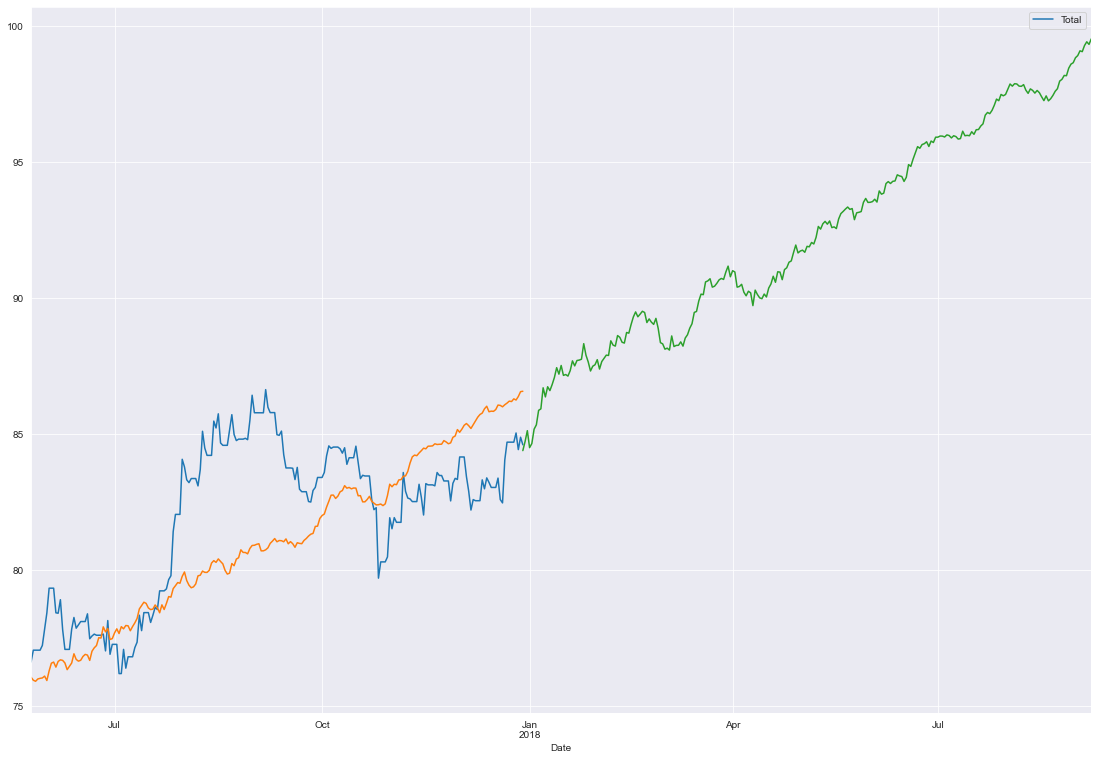

In [21]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:874] # First 80% 
test_df = tot_port_df.iloc[874:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 193).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [22]:
forecast

2017-12-29    84.387030
2017-12-30    84.721591
2017-12-31    85.119670
2018-01-01    84.496014
2018-01-02    84.647682
                ...    
2018-09-03    99.049710
2018-09-04    99.273562
2018-09-05    99.411749
2018-09-06    99.316311
2018-09-07    99.520110
Freq: D, Length: 253, dtype: float64

In [23]:
forecast_df = pd.DataFrame(forecast)

In [24]:
forecast_df

,0
2017-12-29,84.387030
2017-12-30,84.721591
2017-12-31,85.119670
2018-01-01,84.496014
2018-01-02,84.647682
...,...
2018-09-03,99.049710
2018-09-04,99.273562
2018-09-05,99.411749
2018-09-06,99.316311


In [25]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [26]:
return_series

,0
2017-12-29,NaN
2017-12-30,0.003965
2017-12-31,0.008682
2018-01-01,0.001291
2018-01-02,0.003089
...,...
2018-09-03,0.173755
2018-09-04,0.176408
2018-09-05,0.178045
2018-09-06,0.176914


In [27]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2018-09-07  17.932946


## Backtesting

In [28]:
tickers2 = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", "PG", "PGR", "NEM", "CCI"]

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2017-12-29'
end_date = '2018-12-31'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [29]:
panel_data2 = panel_data2['Adj Close']

In [30]:
panel_data2

Symbols,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI
Date,,,,,,,,,,,
2017-12-28,49.810001,43.200001,87.086868,10.550000,80.750000,338.029999,48.054543,81.905396,49.403194,33.218552,95.228302
2017-12-29,49.520000,43.189999,86.273651,10.280000,80.330002,335.959991,47.899426,81.736397,49.237091,33.227417,96.260208
2018-01-02,48.029999,43.599998,88.168976,10.980000,80.440002,348.970001,47.579823,80.642181,48.397823,33.794193,94.456558
2018-01-03,49.730000,43.389999,88.260803,11.550000,81.029999,353.029999,47.692631,80.544334,48.371605,33.510792,94.057678
2018-01-04,50.070000,43.740002,88.778900,12.120000,83.110001,349.790009,47.993439,81.113663,48.362854,33.882744,92.965096
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,45.529999,44.939999,76.151833,16.650000,111.540001,273.519989,63.843082,80.454689,50.952015,31.251417,93.655289
2018-12-26,48.400002,47.430000,79.367104,17.900000,120.220001,285.700012,65.886230,82.968918,52.969749,31.206232,97.045525
2018-12-27,49.160000,47.820000,81.218529,17.490000,121.750000,284.730011,66.695869,84.746353,53.746483,31.621954,97.270920


## Portfolio Analysis

In [31]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI
Date,,,,,,,,,,,
2017-12-29,-0.005822,-0.000232,-0.009338,-0.025592,-0.005201,-0.006124,-0.003228,-0.002063,-0.003362,0.000267,0.010836
2018-01-02,-0.030089,0.009493,0.021969,0.068093,0.001369,0.038725,-0.006672,-0.013387,-0.017045,0.017057,-0.018737
2018-01-03,0.035395,-0.004816,0.001041,0.051913,0.007335,0.011634,0.002371,-0.001213,-0.000542,-0.008386,-0.004223
2018-01-04,0.006837,0.008066,0.005870,0.049351,0.025670,-0.009178,0.006307,0.007069,-0.000181,0.011099,-0.011616
2018-01-05,0.006790,-0.004801,0.009086,-0.019802,0.009265,0.003116,0.009793,0.000658,0.003796,0.003659,0.007649


In [32]:
portfolio_weights = [0.05,0.1,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI
Date,,,,,,,,,,,
2017-12-29,-0.000291,-0.000023,-0.000467,-0.002559,-0.000520,-0.000612,-0.000323,-0.000206,-0.000336,0.000027,0.001084
2018-01-02,-0.001504,0.000949,0.001098,0.006809,0.000137,0.003872,-0.000667,-0.001339,-0.001705,0.001706,-0.001874
2018-01-03,0.001770,-0.000482,0.000052,0.005191,0.000733,0.001163,0.000237,-0.000121,-0.000054,-0.000839,-0.000422
2018-01-04,0.000342,0.000807,0.000294,0.004935,0.002567,-0.000918,0.000631,0.000707,-0.000018,0.001110,-0.001162
2018-01-05,0.000340,-0.000480,0.000454,-0.001980,0.000926,0.000312,0.000979,0.000066,0.000380,0.000366,0.000765


In [33]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2017-12-29   -0.004228
2018-01-02    0.007484
2018-01-03    0.007229
2018-01-04    0.009294
2018-01-05    0.002127
dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2017-12-29
End date,2018-12-31
Total months,12
,Backtest
Annual return,18.3%
Cumulative returns,18.3%
Annual volatility,17.8%
Sharpe ratio,1.03
Calmar ratio,1.15
Stability,0.75
Max drawdown,-16.0%


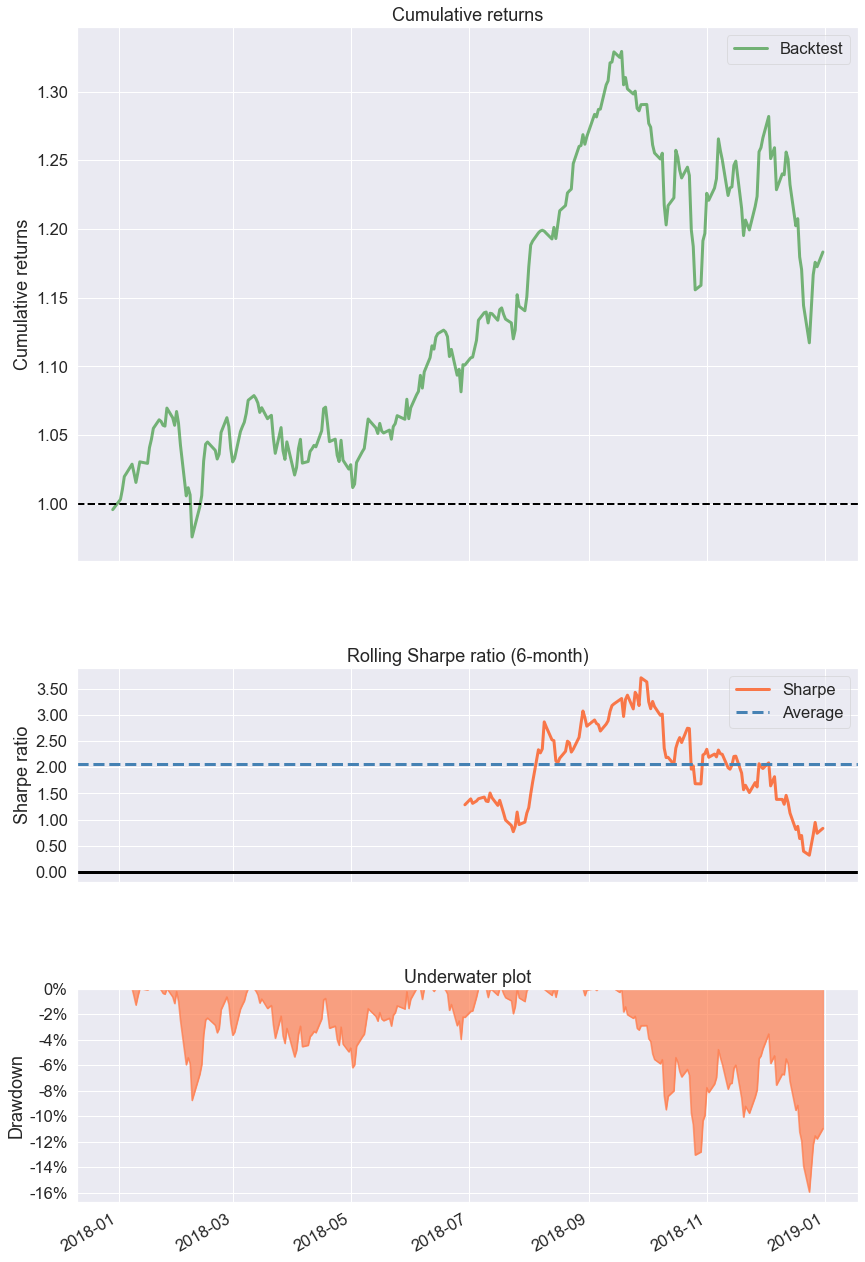

In [34]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [35]:
import itertools

In [36]:
weights = [0.05,0.1,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

In [37]:
panel_data2 = panel_data2 * weights

In [38]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [39]:
#forecasted portfolio value
panel_data2

Symbols,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total
Date,,,,,,,,,,,,
2017-12-28,2.4905,4.320,4.354343,1.055,8.075,33.803000,4.805454,8.190540,4.940319,3.321855,9.522830,84.878842
2017-12-29,2.4760,4.319,4.313683,1.028,8.033,33.595999,4.789943,8.173640,4.923709,3.322742,9.626021,84.601736
2018-01-02,2.4015,4.360,4.408449,1.098,8.044,34.897000,4.757982,8.064218,4.839782,3.379419,9.445656,85.696007
2018-01-03,2.4865,4.339,4.413040,1.155,8.103,35.303000,4.769263,8.054433,4.837160,3.351079,9.405768,86.217244
2018-01-04,2.5035,4.374,4.438945,1.212,8.311,34.979001,4.799344,8.111366,4.836285,3.388274,9.296510,86.250226
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,2.2765,4.494,3.807592,1.665,11.154,27.351999,6.384308,8.045469,5.095201,3.125142,9.365529,82.764740
2018-12-26,2.4200,4.743,3.968355,1.790,12.022,28.570001,6.588623,8.296892,5.296975,3.120623,9.704552,86.521022
2018-12-27,2.4580,4.782,4.060926,1.749,12.175,28.473001,6.669587,8.474635,5.374648,3.162195,9.727092,87.106085


In [40]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [41]:
actual_portfolio_value

[84.87884206771851,
 84.60173559188844,
 85.69600677490234,
 86.2172438621521,
 86.25022554397583,
 86.60276079177856,
 87.37529153823853,
 87.03835945129394,
 86.1437684059143,
 86.77284002304077,
 87.21534633636475,
 87.10384960174561,
 88.16809177398682,
 89.05325403213502,
 89.65445823669434,
 90.42635536193848,
 90.14645948410036,
 90.497696018219,
 90.40846290588378,
 91.23217840194701,
 90.51886672973633,
 90.4985848426819,
 90.86626529693605,
 90.02353801727294,
 90.75809831619264,
 87.5794132232666,
 87.67762489318848,
 86.85376148223877,
 83.75561780929567,
 84.02809858322142,
 85.57803020477296,
 86.03874406814576,
 87.40846128463745,
 88.6293782234192,
 89.05873126983641,
 88.0974739074707,
 88.00294733047485,
 87.93199844360353,
 89.48914794921875,
 89.38629608154298,
 88.39098558425903,
 86.8808876991272,
 86.0921932220459,
 85.84261121749878,
 88.13179817199706,
 87.66370754241944,
 87.85285377502443,
 88.684361743927,
 89.91902837753298,
 91.14284934997559,
 90.18085012

In [42]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [43]:
forecasted_portfolio_value

[84.38702967325477,
 84.72159089423425,
 85.11966986281905,
 84.49601418123186,
 84.64768235648991,
 85.17520955728911,
 85.33450949656411,
 85.86641856840458,
 85.92131914739457,
 86.69578716191432,
 86.36053416689388,
 86.73442502542188,
 86.59253909551364,
 86.81526793187344,
 87.07573229973616,
 87.43536189555158,
 87.19696888661542,
 87.51523395258675,
 87.15168495166756,
 87.18374784937484,
 87.1259364092679,
 87.32534197799875,
 87.6848182986439,
 87.50074344742146,
 87.69900611194984,
 87.71433057260982,
 87.7456787910066,
 88.31745165783317,
 87.89296425137513,
 87.64410673939089,
 87.31318246957777,
 87.48832721319249,
 87.54251157091383,
 87.72961357257176,
 87.3850147620662,
 87.66026751700448,
 87.78118393598731,
 87.89596677667153,
 87.88378619707139,
 88.42222959741758,
 88.26500393573296,
 88.22806853695985,
 88.61544006981333,
 88.54943924616911,
 88.36974522534243,
 88.33904292385844,
 88.72769019047479,
 88.70370161292874,
 89.02218505108517,
 89.30039328515554,
 89.

## Calculate MAPE of forecasted period

In [44]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.05
MAPE % : 5.01 %



In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print(sqrt(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value)))

5.400490492610189
